# Projet Chars74k
Mis au point d'un modèle Deep Learning permettant de faire de la transcription i.e un modèle qui puisse identifier le caractère à l’image.

**Description du Dataset Le dataset Chars74k **

Le dataset Contient des images de caractères de la langue anglaise (alphabet latin) repartie en 62 classes (0-9, A-Z, a-z) comme suit :


*   7705 d'images de caractères issus d’images réelles (EnglishImg)
*    3410 d'images de caractères dessinés sur tablette(EnglishHnd)
*    62992 d'images de caracteres issus de police de caractère(EnglishFnt)

Ceux qui fait au total 74K (d'ou le nom du Dataset chars74K )








# Importons les données de chars74k et commençons à les manipuler.
Pour ce faire, plutôt que d'importer les données à la main, nous allons utiliser un dossier sur le drive associé au compte google connecté à ce colab. Veillez donc à avoir auparavant chargé un dossier nommé 'chars74k' comprenant les trois sous-ensembles du dataset compressé.

Lions notre drive à ce colab avec la commande suivante :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Maintenant que le drive est monté, nous pouvons y naviguer pour trouver nos données ! Pour cela, colab autorise le lancement de commande unix si l'on utilise un '!' devant la commande, comme suit :

In [ ]:
!ls /content/drive

MyDrive  Othercomputers  Shareddrives


On peut voir un élément nommé 'MyDrive' dans le chemin donné pour monter le drive. Explorons ce chemin et tentons d'y trouver le dossier associé à nos données

In [ ]:
!ls /content/drive/MyDrive/chars74K

EnglishFnt.tgz	EnglishHnd.tgz	EnglishImg.tgz


J'observe bien mes trois dossier compressés !

Empressons nous de décompresser ces dossiers, et de récupérer les chemins associés sous forme de variables manipulables :



In [ ]:
# !tar -xzvf "/content/drive/MyDrive/chars74k.tgz" -C "/tmp/"     #[run this cell to extract tar.gz files]



import tarfile
import os
path_to_dataset = '/content/drive/MyDrive/chars74K'


for (root,dir,files) in os.walk(path_to_dataset):
  for filename in files:
    print(os.path.join(root,filename))
    tar = tarfile.open(os.path.join(root,filename))
    tar.extractall()
  break


/content/drive/MyDrive/chars74K/EnglishFnt.tgz
/content/drive/MyDrive/chars74K/EnglishHnd.tgz
/content/drive/MyDrive/chars74K/EnglishImg.tgz


Les données ont été extraites à la racine de ce notebook, explorons ce dernier !

In [ ]:
!ls

drive  English	sample_data


Il y a maintenant un dossier "English" dans ma racine, que je peux aller regarder avec toujours la même commande :

In [ ]:
!ls ./English

Fnt  Hnd  Img


## **Visusalisation des données**

Les données sont réparties entre trois dossiers : Fnt,Hnd,Img (voir description du projet en haut ).

*  Dans Fnt on a 62 sous dossiers qui jouent le role de labels pour les differentes classe de caracteres (0-9 A-Z a-z);

*   Dans Hnd on a un dossier Img qui contient a son tour 62 sous dossiers qui jouent le role de labels pour les differentes classe de caracteres. Nous avons aussi dans Hnd un dossier nommé Trj;

*   Dans Img on a un dossier GoodImg qui a son tour contient deux sous dossiers :
-->Bmp qui contient des images de caracteres reparties en 62 sous dossiers pour chaque classe de caractere (0-9 A-Z a-z);
-->Msk qui corresponde au masques de segmentation binaire des images


On a du utilisé aussi un logiciel pour extraire nos donnée en local (7 Zip) pour mieux voir ce qui se cache dans notre dataset
.



Et voilà mes trois dossiers contenant mes images !
Essayons de visualiser ces dernières ...

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#
# Regardons des blocs de 4*4 de nos images
#
def plot_images(directory):
  nrows = 4
  ncols = 4
  pic_index = 0
  count = 0
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  for classe in os.listdir('%s'%directory):

    sample_dir = os.path.join(directory, '%s'%classe)
    if not os.path.isdir(sample_dir):
      continue
    sample_fnames = os.listdir(sample_dir)
    pic_index += 8
    next_sample001_pix = [os.path.join(sample_dir, fname)
                  for fname in sample_fnames[pic_index-8:pic_index]]
    for i, img_path in enumerate(next_sample001_pix):
      sp = plt.subplot(nrows, ncols, i + 1)
      sp.axis('Off') # Les axes ne seront pas affichés
      img = mpimg.imread(img_path)
      plt.imshow(img)
      count += 1

    plt.show()
  print('Nombre d\'images visualisées :',count)
  print("Taille d'une image aléatoire : {}".format(img.shape))



FNT_directory = '/content/English/Fnt/'
HND_directory = '/content/English/Hnd/Img'
Good_Img_directory = '/content/English/Img/GoodImg/Bmp'
Bad_Img_directory = '/content/English/Img/BadImag/Bmp'



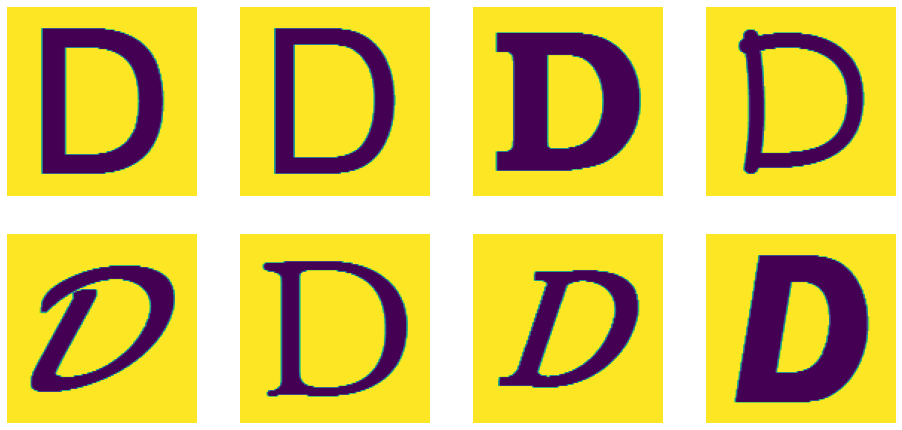

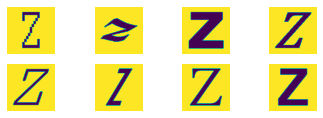

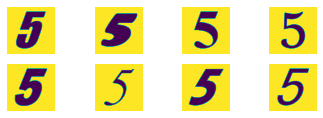

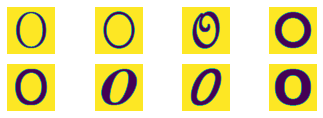

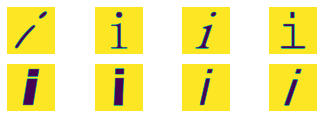

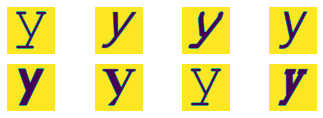

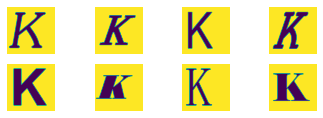

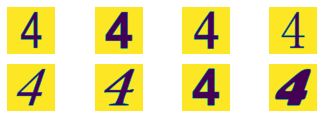

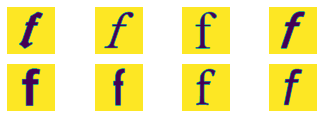

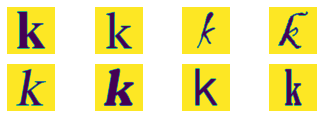

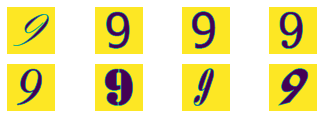

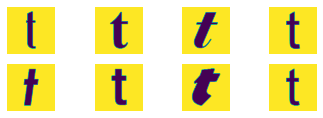

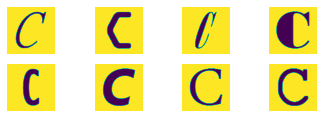

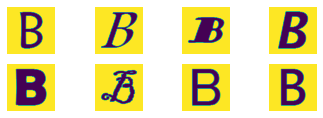

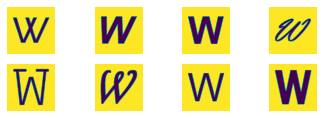

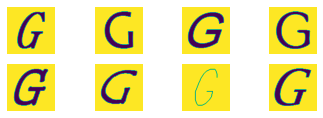

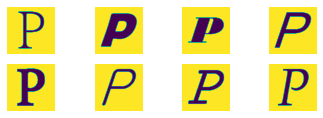

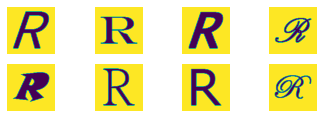

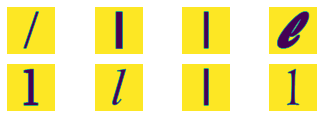

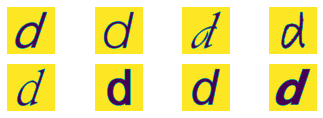

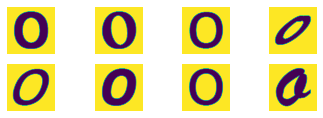

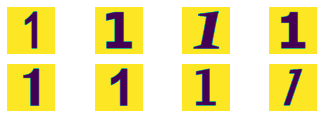

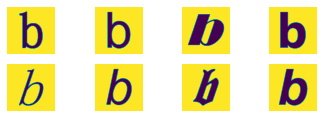

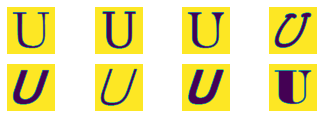

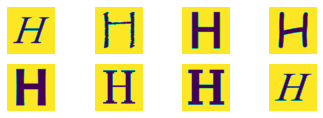

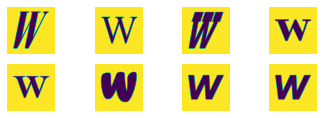

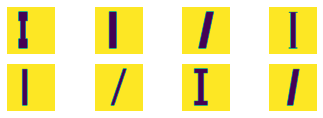

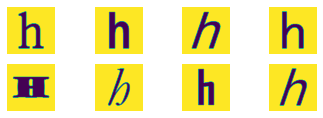

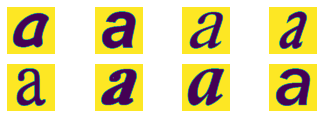

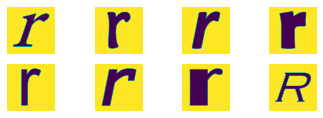

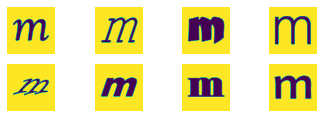

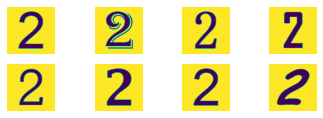

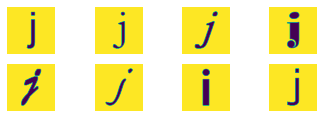

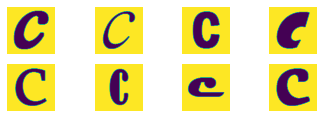

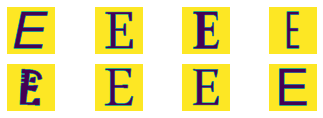

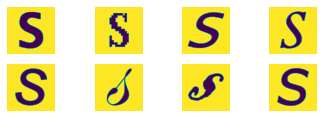

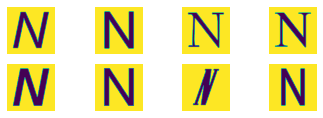

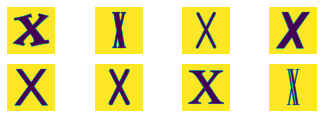

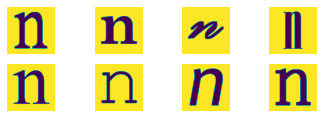

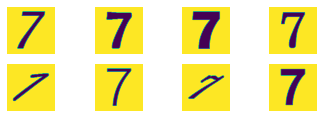

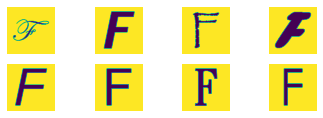

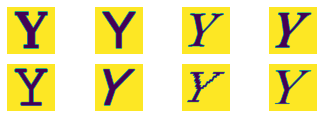

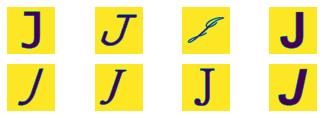

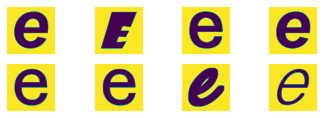

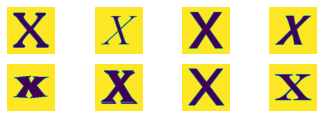

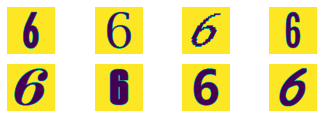

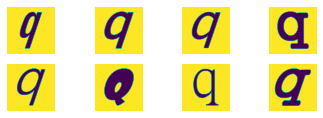

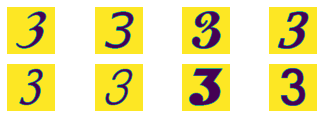

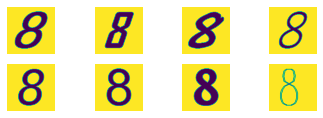

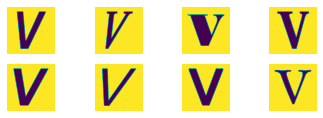

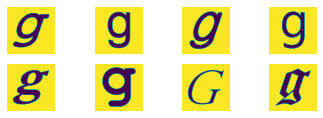

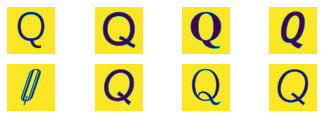

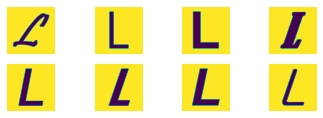

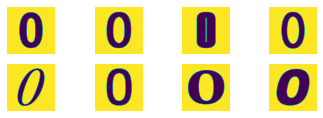

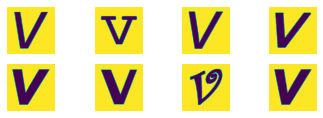

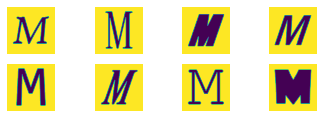

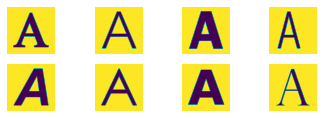

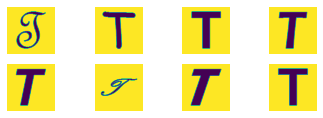

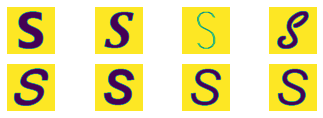

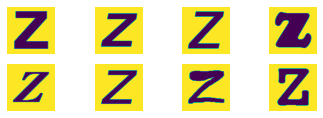

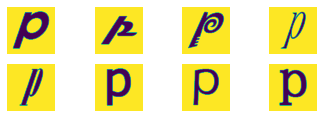

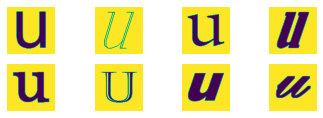

Nombre d'images visualisées : 496
Taille d'une image aléatoire : (128, 128)


In [ ]:
# Visualisons quelques caracteres issues de police de caracteres
plot_images(FNT_directory)

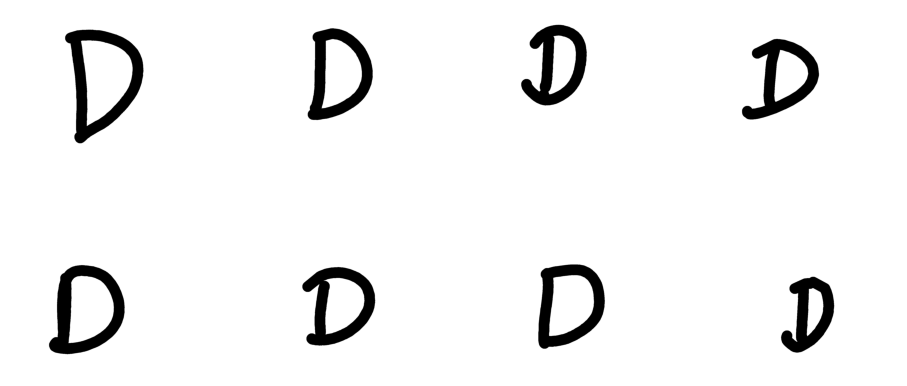

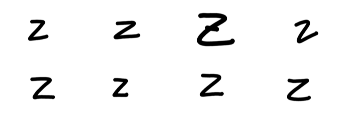

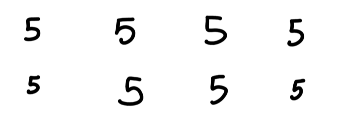

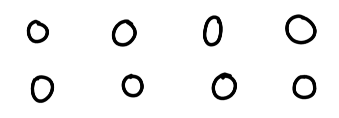

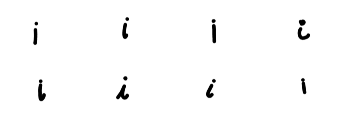

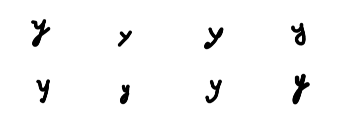

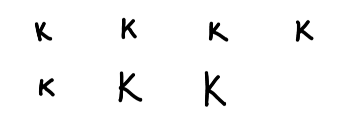

Nombre d'images visualisées : 55
Taille d'une image aléatoire : (900, 1200, 3)


In [ ]:
# Visualisons quelques caracteres manuscrites
plot_images(HND_directory)

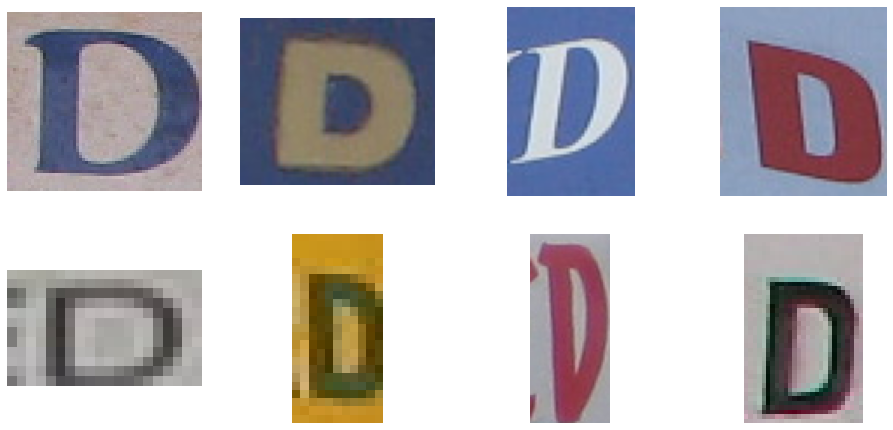

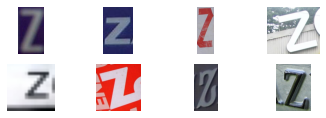

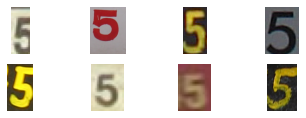

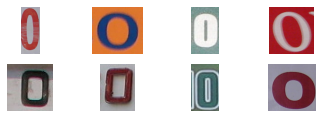

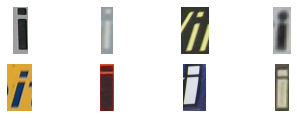

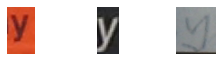

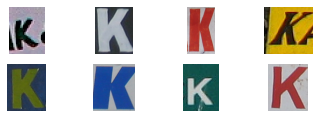

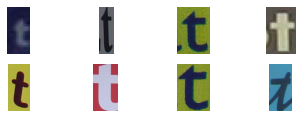

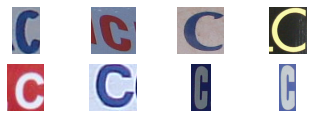

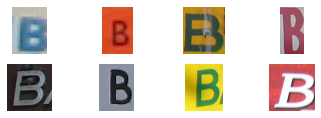

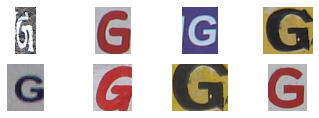

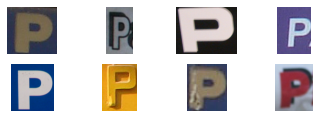

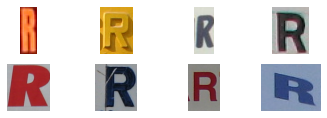

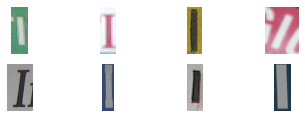

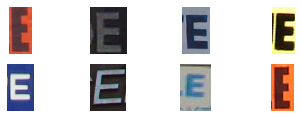

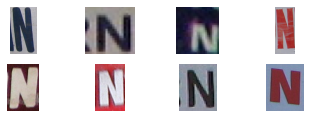

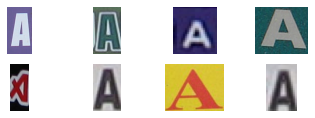

Nombre d'images visualisées : 132
Taille d'une image aléatoire : (23, 15, 3)


In [ ]:
plot_images(Good_Img_directory)

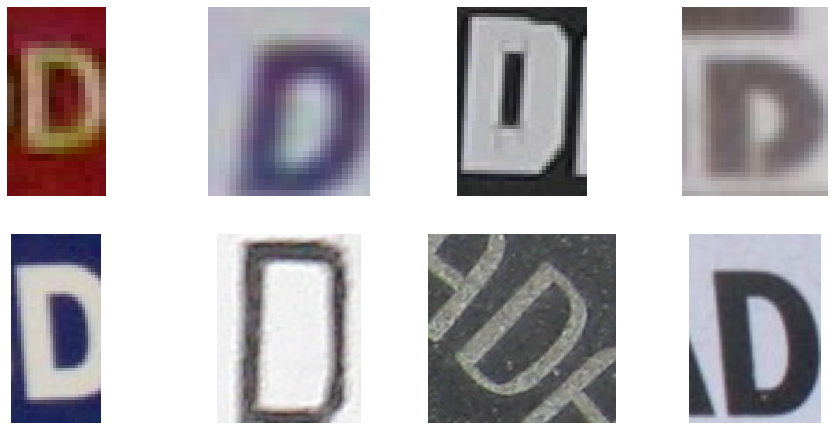

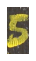

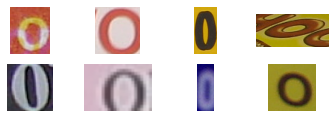

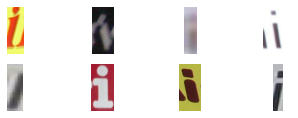

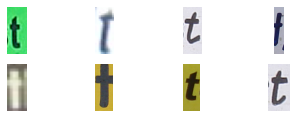

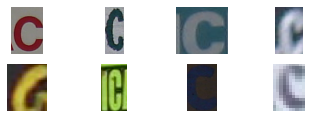

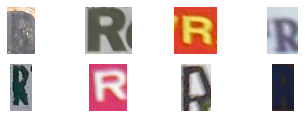

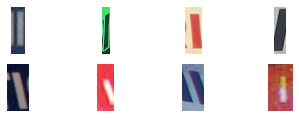

Nombre d'images visualisées : 57
Taille d'une image aléatoire : (53, 27, 3)


In [ ]:
plot_images(Bad_Img_directory)

On observe a l'aide des visualisations ci-dessus:


*   des images disparates : de taille et nature différente
*   une variation entre les polices de caractere pour les images issues de police de caractere (Fnt)

*   une variation entre les caracteres manuscrites
*  une variation entre les caracteres  issus d'images reeles avec des caracteres parfois horizontals ou obliques et quelques images flous aussi et des images pas tres claires (GoodImg)

*   des images majoritairement flous dans le dossier BadImag







**Exploration et formattage des données**

Passons à l'exploration des données.
Commençons par étudier le format des données, la répartition, et ce que les données peuvent nous dire !

In [ ]:
def distribution_directory(directory):
  count = 0
  len_samples = []
  no_duplicate = []
  for classe in os.listdir('%s'%directory):

    sample_dir = os.path.join(directory, '%s'%classe)
    if not os.path.isdir(sample_dir):
      continue
    count += 1
    sample_fnames = os.listdir(sample_dir)
    len_samples.append(len(sample_fnames))

  no_duplicate = list(set(len_samples))
  no_duplicate.sort()
  print(no_duplicate)
  print('Total directories in the subset dataset', count)

In [ ]:
distribution_directory(FNT_directory)

[1016]
Total directories in the subset dataset 62


Ci-dessus,on remarque qu'il y'a 62 repertoires de meme taile(1016) pour chaque classe de caracteres dans le dossier FNT(les caracteres issues de polices de caracteres)

In [ ]:
distribution_directory(HND_directory)

[55]
Total directories in the subset dataset 62


De meme ,on remarque ci-dessus qu'il y'a 62 repertoires de meme taile(55) pour chaque classe de caracteres dans le dossier HND(les caracteres manuscrites).

In [ ]:
distribution_directory(Good_Img_directory)

[32, 33, 34, 35, 36, 37, 38, 41, 43, 46, 47, 48, 50, 52, 54, 55, 58, 63, 64, 67, 70, 77, 79, 80, 84, 92, 105, 111, 115, 124, 126, 127, 135, 143, 148, 149, 158, 159, 191, 193, 215, 227, 302, 312, 342, 363, 382, 389, 446, 558]
Total directories in the subset dataset 62


Ici on a 62 repertoires pour chaque classe de caracteres mais avec une repartition differente en terme de nombre avec des ecarts assez remarquables(32 images pour le plus petit dossier et 558 images pour la plus grande dossier).

On a déjà vu que les images n'avaient pas une taille constante dans ce dataset. Il faudra donc les ramener tous à une même taille, puisque le modèle ne peut pas se permettre de faire varier sa forme d'entrée. Nous devrons donc passer par une étape de formattage de ces données.
Nous ramènerons aussi les valeurs des pixels entre 0 et 1 au lieu de les conserver entre 0 et 255(normalisation).

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32
datagen_args = dict(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,#this is the trick
    rescale=1./255)
def image_data_generator(data_dir,
                       data_augment=False,
                       batch_size=BATCH_SIZE,
                       target_size=(100, 100),
                       color_mode='rgb',
                       class_mode='categorical',
                       shuffle=True,
                       subset="training"
                      ):
  if data_augment:
      datagen = ImageDataGenerator(**datagen_args)
  else:
      datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

  generator = datagen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode=color_mode,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          subset=subset,
                                          class_mode=class_mode)
  return generator


In [ ]:
Fnt_train_generator = image_data_generator(FNT_directory)

Found 50406 images belonging to 62 classes.


In [ ]:
Fnt_val_generator = image_data_generator(FNT_directory,subset='validation')

Found 12586 images belonging to 62 classes.


## **Qu'avons-nous fait dans les lignes précédentes ?**
# datagen = ImageDataGenerator(...)
On utilise ici un outil de preprocessing d'images en keras : **ImageDataGenerator**.

Quelques-uns des principaux avantages de l'utilisation de générateurs de données sont les suivants :

*  Permet de générer des lots(batch) : on peut utiliser des blocs de données plus petits pour entraîner notre modèle à l'aide de la descente de gradient par lots . Et pratiquement tous les ensembles de données du monde réel relatifs à l'apprentissage en profondeur ne peuvent généralement pas tenir en mémoire en une seule fois, c'est donc la seule solution possible la plupart du temps.

*   Permet d'augmenter les données : que nous ayons des données limitées ou que nous souhaitions ajouter de la variété en termes d'augmentation du bruit, c'est ce que nous ferions normalement. Et les générateurs de données aident à le faire à la fois statiquement et à la volée en utilisant les capacités de multitraitement des processeurs modernes.


 L'étape suivante consiste à utiliser la fonction *flow_from _directory* de cet objet (ImageDataGenerator). Cette méthode est utilisée lorsque nos images sont organisées en dossiers sur notre système d'exploitation.
La structure du répertoire doit être la suivante.


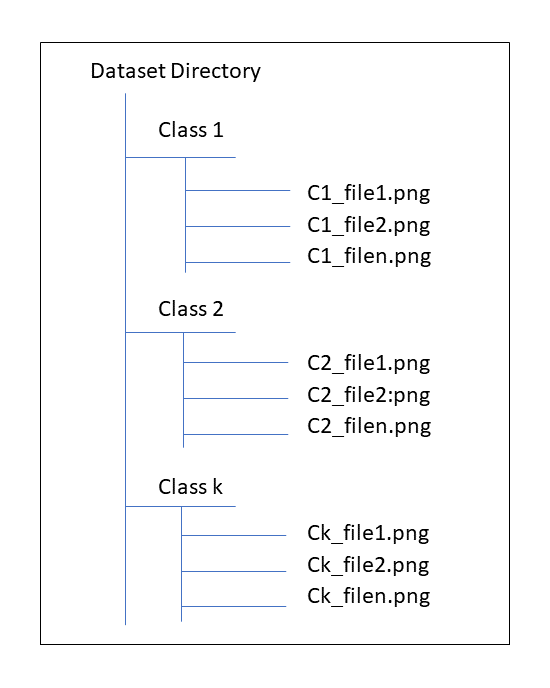


 On renseigne a la methode flow_from_directory avec les arguments suivants :


- chaîne, chemin vers le répertoire cible. Il doit contenir un sous-répertoire par classe.
- la taille des images que nous souhaitons atteindre (ici : 100*100)
- la taille du batch que le générateur devra fournir
- le type de labels qui sera généré. Ici, nous faisons de la classification multiclasse, donc 'categorical' suffira.



# **Passons au model !**

# Un modèle pour faire la transcription !

Comment faire un modèle qui
puisse identifier le caractère à
l’image. ?

Commençons par un modele assez simple un Multi Layer Perceptron !



In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

Fnt_network1 = models.Sequential()
Fnt_network1.add(layers.Dense(32, activation = 'relu', input_shape= (100,100,3,)))
Fnt_network1.add(layers.Flatten())
Fnt_network1.add(layers.Dense(62, activation = 'softmax'))

Faisons un peu de lecture du modèle ci-dessus :



```
Fnt_network1 = models.Sequential()
```
Cette ligne déclare que la variable Fnt_network1 est un modèle qui pourra accueillir des couches.




```
Fnt_network1.add(layers.Dense(32,activation = 'relu', input_shape = (100,100,3)))
```
C'est notre premier ajout de couches ! Il y a quatres éléments à retenir ici :
- le type de couche que nous utilisons est une couche Dense (layers.Dense). C'est la couche la plus simple : tous les neurones de la couche seront connectés à tous les neurones de la couche precedente !
![dense network](https://docs.google.com/uc?export=download&id=1k8sInTooI-qTVfo8eoTbV4LRKv4kuRuL)


- Le nombre de neurones : pour cette première couche, nous avons décidé d'ne utiliser 32. Pourquoi 32 ? Eh bien, il n'y a pas vraiment de raison particulière, il s'agit d'un compromis ! On utilise généralement des puissances de 2 pour des raisons matérielles (question d'optimisation d'accès mémoire). Ensuite, plus on ajoute de neurones, plus notre modèle sera lourd, plus il sera computationnellement lent de l'entrainer ! A l'inverse, en mettre trop peu nous amènerait à avoir un modèle trop peu capable ...  Ici c'est l'expérience qui nous fait désigner le réseau de la sorte (l'approche empirque !)

- l'activation : nous avons utilisé la fonction 'relu' pour l'activation. Mais qu'est-ce qu'un 'relu' ? RELU veut dire REctified Linear Unit, cette fonction correspond à la fonction unité sur la tranche positive des réels et à la fonction nulle sur la tranche négative des réels.
![RELU](https://docs.google.com/uc?export=download&id=1wA90EN0WlZD6z16_YRaQqaTeUmSgtyB3)

- La forme de l'input ! Il faut renseigner la forme des données qui vont être envoyées dans le réseau. Ici, (100 * 100 * 3) correspond à la taille d'une de nos données.

Passons à la ligne suivante.



```
network.add(layers.Dense(62,activation='softmax'))
```

Ceci est notre dernière couche, la couche de sortie. Elle est composée :

- du type de couche. Nous utilisons encore une couche Dense ici.
- du nombre de neurones. Ce nombre revêt un intérêt particulier, puisqu'il définit la taille de l'output. Puisque nous souhaitons un tableau à 62 valeurs. C'est donc 62 neurones dont nous aurons besoin pour nos differentes classes de caracteres.
- de l'activation. Nous souhaitons obtenir des valeurs entre 0 et 1. Ici, l'activation RELU n'est plus adequat : elle peut produire des valeurs au dessus de 1 ... On utilise donc une autre activation,*Softmax*, qui borne les valeurs dans l'intervalle (0,1)

![Softmax](https://docs.google.com/uc?export=download&id=1xDReDAU1jWoDc_eCV7HAXZcm0XPnKOA6)

Pas de couches intermédiaires, nous gardons le réseau le plus simple possible pour limiter les complications.

Et voilà, notre réseau est prêt à être utilisé :!

On peut faire une visualisation de ce dernier avec la commande `summary`

## Et observons à quoi il ressemble avec le méthode `summary` :

In [ ]:
Fnt_network1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 100, 32)      128       
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense_1 (Dense)             (None, 62)                19840062  
                                                                 
Total params: 19,840,190
Trainable params: 19,840,190
Non-trainable params: 0
_________________________________________________________________


## A quel point le modèle est-il mauvais ?

Rappelons-nous le workflow de l'entrainement :


![Softmax](https://docs.google.com/uc?export=download&id=19Ma0VMeHUJQiwhJcHi5ElR-VJffWg2Rs)

Il nous reste pour entrainer notre modèle à définir :

- La loss function, ou fonction de perte : la fonction qui va nous permettre de définir une distance entre deux labels : le label prédit et le label attendu,elle permet de quantifier les erreurs de notre model. Pour des labels sous la forme 'categorical' tels qu'on a actuellement, nous utiliserons une fonction qui est déjà dans keras : 'categorical_crossentropy'

- Il existe plusieurs optimizers qui permettent de remonter l'information dans les poids (ou de parcourir l'espace des solutions et de rechercher un minimum global dans cet espace). Pour cet exemple, nous utiliserons 'rmsprop'

- Enfin, on peut rajouter des métriques que l'on peut suivre durant l'entrainement pour s'informer de son bon déroulement - la précision, par exemple.  

In [ ]:
from tensorflow.keras.optimizers import RMSprop

Fnt_network1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

## S'entrainer à partir de générateurs

Nous avons plus haut fabriqué ce qu'on appelle un générateur d'images. Comment utiliser ce dernier pour que les données soient fournis au réseau pour l'entrainement ?

Il existe une méthode simple pour cela, appelée `fit_generator`. On lui passe en paramètre :
- le générateur de données d'entrainement
- le nombre d'étapes pour considérer qu'on a fait le tour des données (une epoch)
- le nombre de fois où nous fournirons toutes les données au modèle (nombre d'epochs)
- le générateur de données de validation
- le nombre d'étapes pour considérer qu'on a fait le tour des données de validation

RAPPEL : La validation, c'est le principe de faire un test après chaque époque (entrainement sur le jeu de données d'entrainement entier) avec des données qui ne servent pas à l'entrainement. L'optimizer utilisera le score de perte d'entrainement pour calculer les modifications à faire sur les poids. Ceci est une mesure qui permet :
- de constater l'overfitting (surentrainement) lorsqu'il y en a
- de limiter ce dernier


In [ ]:
import math
epochs = 32
Fnt_history = Fnt_network1.fit_generator(
      Fnt_train_generator,
      steps_per_epoch=math.ceil(Fnt_train_generator.samples//BATCH_SIZE),
      epochs=epochs,
      validation_data=Fnt_val_generator,
      validation_steps=math.ceil(Fnt_val_generator.samples//BATCH_SIZE),
      verbose=2)

Epoch 1/32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


1575/1575 - 35s - loss: 0.7371 - acc: 0.8099 - val_loss: 0.7271 - val_acc: 0.8005 - 35s/epoch - 22ms/step
Epoch 2/32
1575/1575 - 35s - loss: 0.7309 - acc: 0.8105 - val_loss: 0.7427 - val_acc: 0.8018 - 35s/epoch - 22ms/step
Epoch 3/32
1575/1575 - 35s - loss: 0.7254 - acc: 0.8121 - val_loss: 0.7282 - val_acc: 0.8062 - 35s/epoch - 22ms/step
Epoch 4/32
1575/1575 - 35s - loss: 0.7209 - acc: 0.8140 - val_loss: 0.7581 - val_acc: 0.8042 - 35s/epoch - 22ms/step
Epoch 5/32
1575/1575 - 35s - loss: 0.7158 - acc: 0.8157 - val_loss: 0.7317 - val_acc: 0.8027 - 35s/epoch - 22ms/step
Epoch 6/32
1575/1575 - 35s - loss: 0.7134 - acc: 0.8158 - val_loss: 0.7380 - val_acc: 0.8045 - 35s/epoch - 22ms/step
Epoch 7/32
1575/1575 - 35s - loss: 0.7089 - acc: 0.8167 - val_loss: 0.7872 - val_acc: 0.8042 - 35s/epoch - 22ms/step
Epoch 8/32
1575/1575 - 35s - loss: 0.7046 - acc: 0.8173 - val_loss: 0.7113 - val_acc: 0.8054 - 35s/epoch - 22ms/step
Epoch 9/32
1575/1575 - 35s - loss: 0.7018 - acc: 0.8187 - val_loss: 0.7074 

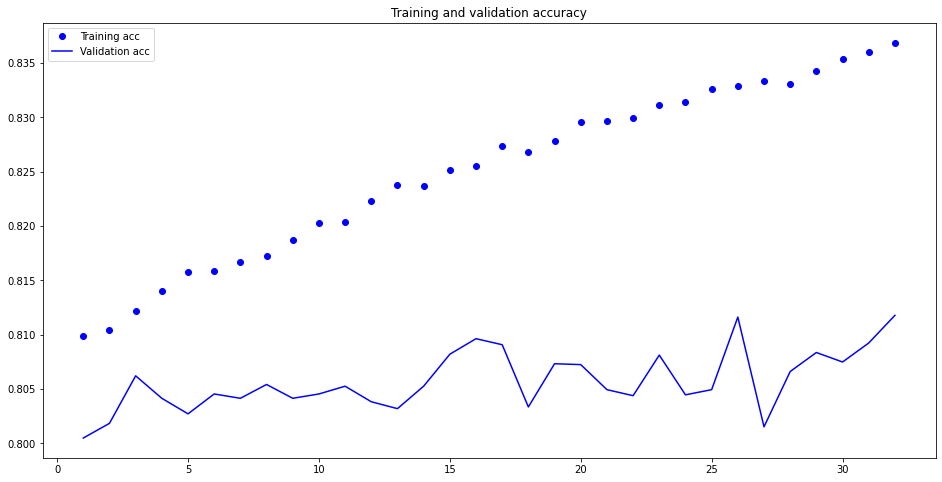

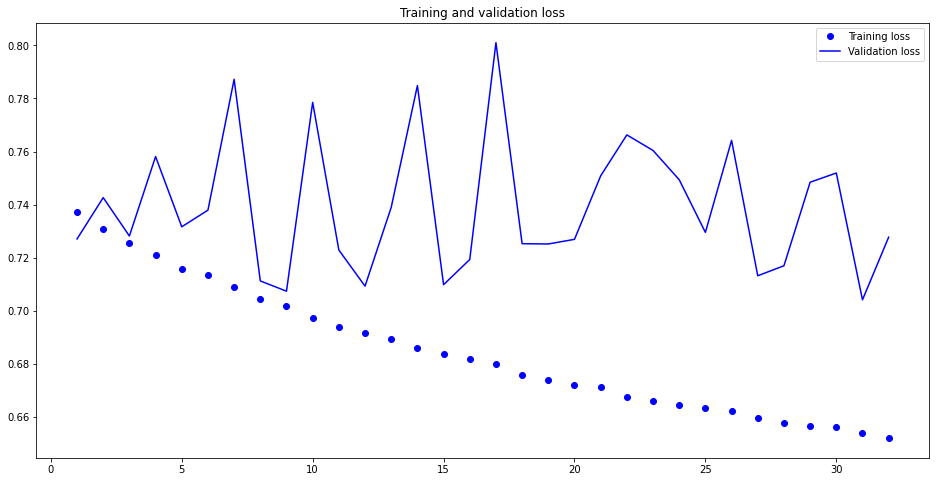

In [ ]:
acc = Fnt_history.history['acc']
val_acc = Fnt_history.history['val_acc']
loss = Fnt_history.history['loss']
val_loss = Fnt_history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Sauvegarder le modèle
Evaluons le modèle et procédons ensuite à la sauvegarde de l'état du modèle !

In [ ]:
Fnt_network1.evaluate(Fnt_val_generator)
Fnt_network1.save('Fnt_saved_model')

394/394 [==============================] - 7s 17ms/step - loss: 0.7277 - acc: 0.8118
INFO:tensorflow:Assets written to: Fnt_saved_model/assets


Le modèle est maintenant sauvegardé !

On peut voir le dossier qui a été créé à la racine de ce notebook, du nom "saved_model", et qui contient les données relatives à notre modèle !

#Charger le modèle

Pour charger le modèle, il faudra renseigner le chemin vers ce dossier qui contient les informations nécessaires !

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('Fnt_saved_model')
loaded_model.evaluate(Fnt_val_generator)

394/394 [==============================] - 7s 18ms/step - loss: 0.7277 - acc: 0.8118


[0.7277256846427917, 0.8117749691009521]

In [ ]:
Good_Img_train_generator = image_data_generator(Good_Img_directory)

Found 6190 images belonging to 62 classes.


In [ ]:

Good_Img_val_generator = image_data_generator(Good_Img_directory,subset="validation")

Found 1515 images belonging to 62 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
def default_layers ():

  model = models.Sequential()
  model.add(layers.Dense(32, activation = 'relu', input_shape= (100,100,3,)))
  model.add(layers.Flatten())
  model.add(layers.Dense(62, activation = 'softmax'))
  model.summary()
  return model


In [ ]:
from keras.backend import categorical_crossentropy
def compilation(model,loss='categorical_crossentropy',optimizer="rmsprop",metrics=['acc']):
  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
  return model

In [ ]:
def default_training(compiled_model,train_generator,val_generator,batch_size=BATCH_SIZE,epochs=16,verbose=2):
  history = compiled_model.fit_generator(
      train_generator,
      steps_per_epoch=math.ceil(train_generator.samples//batch_size),
      epochs=epochs,
      validation_data=val_generator,
      validation_steps=math.ceil(val_generator.samples//batch_size),
      verbose=verbose)
  return history

In [ ]:
good_img_layers =default_layers()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100, 100, 32)      128       
                                                                 
 flatten_2 (Flatten)         (None, 320000)            0         
                                                                 
 dense_5 (Dense)             (None, 62)                19840062  
                                                                 
Total params: 19,840,190
Trainable params: 19,840,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
good_img_network = compilation(good_img_layers)

In [ ]:
good_img_history = default_training(good_img_network,Good_Img_train_generator,Good_Img_val_generator)

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


193/193 - 8s - loss: 15.3345 - acc: 0.0682 - val_loss: 4.2321 - val_acc: 0.1011 - 8s/epoch - 44ms/step
Epoch 2/16
193/193 - 7s - loss: 3.6814 - acc: 0.1924 - val_loss: 4.5335 - val_acc: 0.0944 - 7s/epoch - 35ms/step
Epoch 3/16
193/193 - 8s - loss: 3.2825 - acc: 0.2938 - val_loss: 4.9148 - val_acc: 0.1031 - 8s/epoch - 39ms/step
Epoch 4/16
193/193 - 7s - loss: 2.8792 - acc: 0.3782 - val_loss: 5.7670 - val_acc: 0.1104 - 7s/epoch - 35ms/step
Epoch 5/16
193/193 - 8s - loss: 2.5224 - acc: 0.4584 - val_loss: 6.4147 - val_acc: 0.1117 - 8s/epoch - 39ms/step
Epoch 6/16
193/193 - 7s - loss: 2.2184 - acc: 0.5237 - val_loss: 7.0767 - val_acc: 0.1104 - 7s/epoch - 34ms/step
Epoch 7/16
193/193 - 8s - loss: 1.9853 - acc: 0.5779 - val_loss: 7.7418 - val_acc: 0.1197 - 8s/epoch - 40ms/step
Epoch 8/16
193/193 - 7s - loss: 1.7766 - acc: 0.6185 - val_loss: 8.0175 - val_acc: 0.1164 - 7s/epoch - 35ms/step
Epoch 9/16
193/193 - 7s - loss: 1.5800 - acc: 0.6569 - val_loss: 8.7478 - val_acc: 0.1203 - 7s/epoch - 35m

In [ ]:
good_img_history = default_training(good_img_network,Good_Img_train_generator,Good_Img_val_generator,epochs=32)

Epoch 1/32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


193/193 - 7s - loss: 0.6978 - acc: 0.8482 - val_loss: 12.7534 - val_acc: 0.1117 - 7s/epoch - 36ms/step
Epoch 2/32
193/193 - 7s - loss: 0.6332 - acc: 0.8613 - val_loss: 13.1028 - val_acc: 0.1144 - 7s/epoch - 35ms/step
Epoch 3/32
193/193 - 7s - loss: 0.5634 - acc: 0.8763 - val_loss: 13.7011 - val_acc: 0.1084 - 7s/epoch - 35ms/step
Epoch 4/32
193/193 - 7s - loss: 0.5171 - acc: 0.8896 - val_loss: 14.2248 - val_acc: 0.1157 - 7s/epoch - 36ms/step
Epoch 5/32
193/193 - 7s - loss: 0.4621 - acc: 0.9022 - val_loss: 15.0854 - val_acc: 0.1117 - 7s/epoch - 35ms/step
Epoch 6/32
193/193 - 7s - loss: 0.4137 - acc: 0.9131 - val_loss: 15.2105 - val_acc: 0.1137 - 7s/epoch - 35ms/step
Epoch 7/32
193/193 - 7s - loss: 0.3860 - acc: 0.9177 - val_loss: 15.5009 - val_acc: 0.1130 - 7s/epoch - 36ms/step
Epoch 8/32
193/193 - 8s - loss: 0.3539 - acc: 0.9245 - val_loss: 15.5322 - val_acc: 0.1190 - 8s/epoch - 39ms/step
Epoch 9/32
193/193 - 7s - loss: 0.3047 - acc: 0.9342 - val_loss: 16.6838 - val_acc: 0.1064 - 7s/epo

In [ ]:
Hnd_train_generator = image_data_generator(HND_directory)

Found 2728 images belonging to 62 classes.


In [ ]:
Hnd_val_generator = image_data_generator(HND_directory,subset="validation")

Found 682 images belonging to 62 classes.


In [ ]:
hnd_layers =default_layers()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100, 100, 32)      128       
                                                                 
 flatten_3 (Flatten)         (None, 320000)            0         
                                                                 
 dense_7 (Dense)             (None, 62)                19840062  
                                                                 
Total params: 19,840,190
Trainable params: 19,840,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hnd_network = compilation(hnd_layers)

In [ ]:
good_img_history = default_training(hnd_network,Hnd_train_generator,Hnd_val_generator,epochs=32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/32
85/85 - 41s - loss: 111.4130 - acc: 0.0163 - val_loss: 37.3685 - val_acc: 0.0164 - 41s/epoch - 477ms/step
Epoch 2/32
85/85 - 39s - loss: 15.4363 - acc: 0.0197 - val_loss: 5.6837 - val_acc: 0.0179 - 39s/epoch - 459ms/step
Epoch 3/32
85/85 - 40s - loss: 4.2231 - acc: 0.0286 - val_loss: 4.0910 - val_acc: 0.0521 - 40s/epoch - 465ms/step
Epoch 4/32
85/85 - 37s - loss: 4.1162 - acc: 0.0249 - val_loss: 4.1271 - val_acc: 0.0164 - 37s/epoch - 433ms/step
Epoch 5/32
85/85 - 39s - loss: 4.1278 - acc: 0.0145 - val_loss: 4.1271 - val_acc: 0.0164 - 39s/epoch - 462ms/step
Epoch 6/32
85/85 - 37s - loss: 4.1278 - acc: 0.0141 - val_loss: 4.1272 - val_acc: 0.0164 - 37s/epoch - 432ms/step
Epoch 7/32
85/85 - 39s - loss: 4.1278 - acc: 0.0104 - val_loss: 4.1271 - val_acc: 0.0164 - 39s/epoch - 463ms/step
Epoch 8/32
85/85 - 37s - loss: 4.1278 - acc: 0.0111 - val_loss: 4.1271 - val_acc: 0.0164 - 37s/epoch - 431ms/step
Epoch 9/32
85/85 - 36s - loss: 4.1278 - acc: 0.0159 - val_loss: 4.1271 - val_acc: 0.